In [1277]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

In [1278]:
# GLOBAL VARS
dataset_size = 8000
lr_faces = 5e-6
lr_scenes = 1e-4
lr_model = 1e-4
batch_size = 32
log_iter = 2
epochs = 5
load_model = False

In [1279]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [1280]:
# # try to read all the images to see if any are missing or corrupted
# df = pd.read_csv(os.path.join(findingemo_dir, "annotations_single.ann"))

# # Delete the columns: "user" and "index" and "datetime"
# if "user" in df.columns and "index" in df.columns and "datetime" in df.columns:
#     df = df.drop(columns=["user", "index", "datetime"])

# # remove leading slash from image_path
# if df["image_path"].iloc[0].startswith("/"):
#     df["image_path"] = df["image_path"].str.lstrip("/")

# # in the dataframe image_path column, change all the occurences of 'lmertens' to 'anon'
# df["image_path"] = df["image_path"].str.replace("lmertens", "anon", regex=False)
# # change the occurences of *, : ? in the image_path to _
# df["image_path"] = df["image_path"].str.replace("*", "_", regex=False)
# df["image_path"] = df["image_path"].str.replace(":", "_", regex=False)
# df["image_path"] = df["image_path"].str.replace("?", "_", regex=False)

# corrupted_indices = []
# for idx, row in df.iterrows():
#     if idx % 100 == 0:
#         print(f"Checking image {idx}/{len(df)}")
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     try:
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image at index {idx} could not be read: {img_path}")
#             corrupted_indices.append(idx)
#     except Exception as e:
#         print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
# print(f"Total corrupted/missing images: {len(corrupted_indices)}")
# print("Corrupted indices:", corrupted_indices)
# # Remove corrupted entries from dataframe
# df = df.drop(index=corrupted_indices).reset_index(drop=True)
# # save the cleaned dataframe as pickle
# df.to_pickle("clean_findingemo.pkl")

df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [1281]:
# corrupted_indices = []
# for idx, row in df.iterrows():
#     if idx % 100 == 0:
#         print(f"Checking image {idx}/{len(df)}")
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     try:
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image at index {idx} could not be read: {img_path}")
#             corrupted_indices.append(idx)
#     except Exception as e:
#         print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
# print(f"Total corrupted/missing images: {len(corrupted_indices)}")
# print("Corrupted indices:", corrupted_indices)

In [1282]:
# set device, move models and maps, set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1283]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0


In [1284]:
len(df)

25867

In [1285]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [1286]:
df.tail()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
7995,Run_2/Raging children funeral/2424B45F00000578...,Undefined,Adults,2,3,Joy,"BodyLanguage,FacialExpression",1
7996,Run_2/Accepting people library/big-image-rakhi...,Undefined,"Children,Young Adults",-2,3,Sadness,Context,2
7997,Run_2/Displeased students funeral/asphyxia_171...,Undefined,"Young Adults,Adults",-1,4,Grief,Staging,1
7998,Run_2/Accepting teenagers mall/21097-nuclear-f...,Undefined,"Children,Youth,Young Adults,Adults",2,4,Trust,"BodyLanguage,FacialExpression",1
7999,Run_2/Aggressive people meeting/CN9v8iKVAAADxE...,Undefined,Adults,1,2,Trust,Neutral,0


In [1287]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]

In [1288]:
# I'm going to simplify the emotions to happy, sad and neutral first
df['emo8'] = df['emotion'].apply(emo_8_mapping).str.lower()

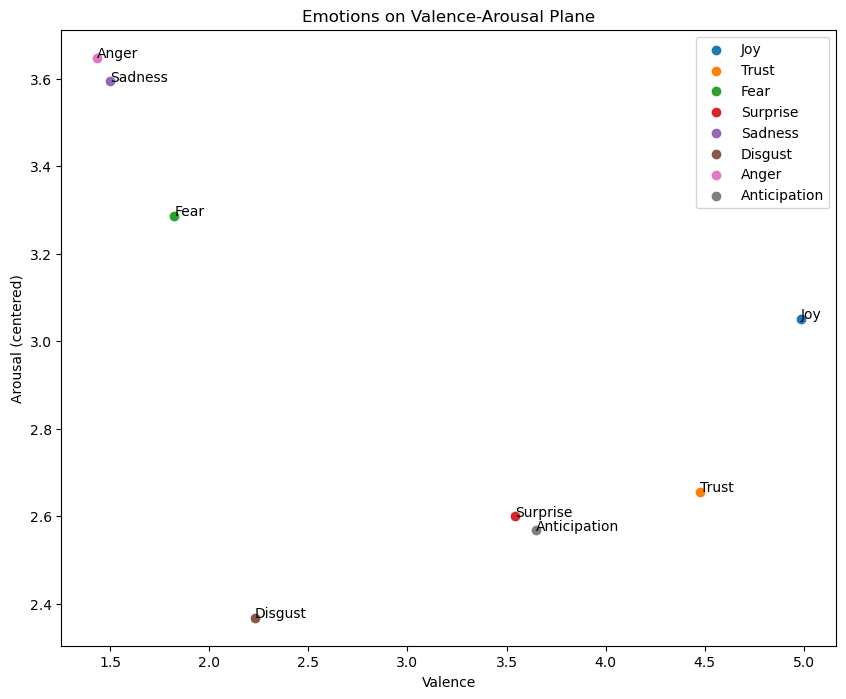

In [1289]:
# Print the average valence and arousal value for each emo8 class
# print the emotions on a 2D valence-arousal plane
plt.figure(figsize=(10, 8))
for emo in [leaf[1] for leaf in EMOTION_SETS]:
    subset = df[df['emo8'] == emo.lower()]
    avg_valence = subset['valence'].mean() + 3
    avg_arousal = subset['arousal'].mean()
    plt.scatter(avg_valence, avg_arousal, label=emo)
    plt.text(avg_valence, avg_arousal, emo)
plt.xlabel('Valence')
plt.ylabel('Arousal (centered)')
plt.title('Emotions on Valence-Arousal Plane')
plt.legend()
plt.show()

In [1290]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,emo8
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0,trust
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0,anticipation
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3,anticipation
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4,anticipation
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0,fear


In [1291]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [1292]:
# read the csv file from the data folder
categories_365_path = os.path.join(data_dir, "CategoriesPlaces365.xlsx")

# read as csv
categories_365_df = pd.read_excel(categories_365_path)
categories_365_df.head()

,commercial,summer,sport,playful,royal,relaxing,house_interior,food,cold,scary,transport,work,nature,horeca,agriculture,depressing,industrial,urban,cultural,woods
0,bakery_shop,harbor,arena_hockey,nursery,banquet_hall,jacuzzi_indoor,living_room,pantry,crevasse,attic,airfield,home_office,viaduct,bar,vegetable_garden,hospital,assembly_line,building_facade,church_outdoor,hunting_lodge_outdoor
1,butchers_shop,berth,arena_performance,playroom,ballroom,bedroom,kitchen,dining_room,mountain_snowy,basement,airplane_cabin,bank_vault,dam,pub_indoor,wheat_field,hospital_room,auto_factory,downtown,mosque_outdoor,cottage
2,clothing_store,coast,arena_rodeo,childs_room,bedchamber,bathroom,closet,fastfood_restaurant,ice_floe,alley,airport_terminal,server_room,badlands,cafeteria,wind_farm,jail_cell,engine_room,street,synagogue_outdoor,tree_house
3,department_store,grotto,baseball_field,candy_store,auto_showroom,television_room,dorm_room,restaurant,ice_shelf,catacomb,railroad_track,auditorium,canyon,coffee_shop,barn,army_base,industrial_area,shopfront,temple_asia,inn_outdoor
4,jewelry_shop,islet,basketball_court_indoor,florist_shop_indoor,church_indoor,shower,hotel_room,restaurant_kitchen,iceberg,NaN,train_interior,classroom,cliff,pub_indoor,farm,trench,oilrig,parking_lot,mausoleum,NaN


In [1293]:
# get the counts of the labels of emo8
df['emo8'].value_counts()

emo8
joy             2272
anticipation    1777
trust           1230
sadness          792
fear             683
anger            682
disgust          304
surprise         260
Name: count, dtype: int64

In [1294]:
# From the dataframe, create a dictionary that maps every category to its broader category (column where it belongs)
category_mapping = {}
for col in categories_365_df.columns:
    for category in categories_365_df[col].dropna().tolist():
        category_mapping[category] = col

mapped_categories = sorted(list(dict.fromkeys(category_mapping.values())))
print("Mapped Categories:", mapped_categories)

Mapped Categories: ['agriculture', 'cold', 'commercial', 'cultural', 'depressing', 'food', 'horeca', 'house_interior', 'industrial', 'nature', 'playful', 'relaxing', 'royal', 'scary', 'sport', 'summer', 'transport', 'urban', 'woods', 'work']


In [1295]:
errors = 0
# Check if all the 365 categories are in the mapping
for cat in scene_categories:
    if cat not in category_mapping:
        print("Category not found in mapping:", cat)
        errors += 1

# check if all keys in category_mapping are in scene_categories
for cat in category_mapping.keys():
    if cat not in scene_categories:
        print("Category in mapping not found in scene categories:", cat)
        errors += 1

assert(errors == 0)

In [1296]:
# Build mapping matrix with deterministic column order and float dtype
map_365 = torch.zeros((365, len(mapped_categories)), dtype=torch.float32)
for i, cat in enumerate(scene_categories):
    coarse = category_mapping[cat]
    coarse_idx = mapped_categories.index(coarse)
    map_365[i, coarse_idx] = 1.0

In [1297]:
def get_mapped_category(scene_idx_365):
    # print the name of the 365 category
    mapped = map_365[scene_idx_365]
    mapped_idx = torch.argmax(mapped).item()
    print(scene_categories[scene_idx_365], "->", mapped_categories[mapped_idx])

In [1298]:
N = dataset_size
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 6400
Test indices length: 1600


In [1299]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [1300]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [1301]:
# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

In [1302]:
# faces_dir = os.path.join(findingemo_dir, "faces")
# os.makedirs(faces_dir, exist_ok=True)

# csv_path = os.path.join(findingemo_dir, "face_boxes.csv")

# # Create and open CSV file for writing
# with open(csv_path, "w", newline="") as f:
#     writer = csv.writer(f)
#     # header row
#     writer.writerow(["index", "image_path", "face_rank", "x1", "y1", "x2", "y2", "score", "crop_path"])

#     # ========================================
#     # Iterate over the dataframe and process each image
#     # ========================================
#     for idx, row in tqdm(df.iterrows(), total=len(df), desc="Detecting faces"):
#         img_path = os.path.join(findingemo_dir, row["image_path"])

#         try:
#             detections = RetinaFace.detect_faces(img_path)
#         except Exception as e:
#             print(f"[Warning] Could not process {img_path}: {e}")
#             continue

#         # Skip images without faces
#         if not detections or isinstance(detections, str):
#             continue

#         # Collect all detected faces
#         faces = []
#         for det in detections.values():
#             x1, y1, x2, y2 = det["facial_area"]
#             area = (x2 - x1) * (y2 - y1)
#             faces.append({
#                 "coords": (x1, y1, x2, y2),
#                 "score": det["score"],
#                 "area": area
#             })

#         # Sort faces by area (largest first) and keep top 3
#         faces = sorted(faces, key=lambda x: x["area"], reverse=True)[:3]

#         # Crop and save top faces
#         img = Image.open(img_path).convert("RGB")
#         for i, face in enumerate(faces):
#             x1, y1, x2, y2 = face["coords"]
#             crop = img.crop((x1, y1, x2, y2)).resize((224, 224))
#             crop_name = f"img_{idx}_face_{i}.jpg"
#             crop_path = os.path.join(faces_dir, crop_name)
#             crop.save(crop_path, "JPEG", quality=90)

#             # Write bounding box info to CSV
#             writer.writerow([
#                 idx,                      # image index
#                 row["image_path"],        # relative image path
#                 i,                        # face rank (0=largest)
#                 x1, y1, x2, y2,           # bounding box coordinates
#                 face["score"],            # detection confidence
#                 crop_path                 # saved crop file
#             ])

# print(f"Finished! Cropped faces saved in: {faces_dir}")
# print(f"Bounding box CSV saved at: {csv_path}")


In [1303]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes.csv"))

In [1304]:
df_boxes.head()

,index,image_path,face_rank,x1,y1,x2,y2,score,crop_path
0,0,Run_2/Loving toddlers sports/haiti-kids.jpg,0,236,226,284,292,0.998141,c:\Users\jarne\Documents\Code Masterthesis\nsa...
1,0,Run_2/Loving toddlers sports/haiti-kids.jpg,1,634,129,683,192,0.999440,c:\Users\jarne\Documents\Code Masterthesis\nsa...
2,0,Run_2/Loving toddlers sports/haiti-kids.jpg,2,133,246,181,307,0.999333,c:\Users\jarne\Documents\Code Masterthesis\nsa...
3,1,Run_2/Frustrated forty-something office/team-w...,0,113,277,180,411,0.941503,c:\Users\jarne\Documents\Code Masterthesis\nsa...
4,1,Run_2/Frustrated forty-something office/team-w...,1,242,80,300,165,0.999143,c:\Users\jarne\Documents\Code Masterthesis\nsa...


In [1305]:
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [1306]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,emo8,nr_faces
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0,trust,3
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0,anticipation,3
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3,anticipation,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4,anticipation,3
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0,fear,3


In [1307]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig


emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [1308]:
class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor['pixel_values'][0]
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
train_faces_dataset = FacesDataset(train_indices)
test_faces_dataset = FacesDataset(test_indices)

In [1309]:
class FaceNet(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)

        x = x.to(next(self.parameters()).device)
        outputs = self.base_model(x)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        return probs
    
face_model = FaceNet(face_model_base)
face_model.to(DEVICE)
print("Face model initialized")

Face model initialized


In [1310]:
face_model

FaceNet(
  (base_model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTIntermediate(
              (dense): Line

In [1311]:
# Freeze embeddings
for param in face_model_base.vit.embeddings.parameters():
    param.requires_grad = False

# Freeze encoder layers 0–9
for layer in face_model_base.vit.encoder.layer[:10]:
    for param in layer.parameters():
        param.requires_grad = False

# UNFREEZE encoder layers 10 and 11
for layer in face_model_base.vit.encoder.layer[10:]:
    for param in layer.parameters():
        param.requires_grad = True

# Freeze final layernorm (optional—but generally recommended to UNFREEZE it)
for param in face_model_base.vit.layernorm.parameters():
    param.requires_grad = True   # <--- IMPORTANT: allow adaptation!

# Train classifier head
for param in face_model_base.classifier.parameters():
    param.requires_grad = True


In [1312]:
trainable = [name for name, p in face_model.named_parameters() if p.requires_grad]
print("Trainable parameters:", trainable)

Trainable parameters: ['base_model.vit.encoder.layer.10.attention.attention.query.weight', 'base_model.vit.encoder.layer.10.attention.attention.query.bias', 'base_model.vit.encoder.layer.10.attention.attention.key.weight', 'base_model.vit.encoder.layer.10.attention.attention.key.bias', 'base_model.vit.encoder.layer.10.attention.attention.value.weight', 'base_model.vit.encoder.layer.10.attention.attention.value.bias', 'base_model.vit.encoder.layer.10.attention.output.dense.weight', 'base_model.vit.encoder.layer.10.attention.output.dense.bias', 'base_model.vit.encoder.layer.10.intermediate.dense.weight', 'base_model.vit.encoder.layer.10.intermediate.dense.bias', 'base_model.vit.encoder.layer.10.output.dense.weight', 'base_model.vit.encoder.layer.10.output.dense.bias', 'base_model.vit.encoder.layer.10.layernorm_before.weight', 'base_model.vit.encoder.layer.10.layernorm_before.bias', 'base_model.vit.encoder.layer.10.layernorm_after.weight', 'base_model.vit.encoder.layer.10.layernorm_after.

In [1313]:
face_network = Network(face_model, "face_model", batching=True)
face_network.optimizer = torch.optim.Adam(face_model.parameters(), lr=lr_faces)

In [1314]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)

print("Loaded pretrained models")

Loaded pretrained models


In [1315]:
class SceneNet(nn.Module):
    def __init__(self, pretrained_model, map_365 = map_365):
        super().__init__()
        self.base = pretrained_model
        self.register_buffer("map_365", map_365.clone().float())

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)

        x = x.to(next(self.parameters()).device)
        logits = self.base(x)
        probs = torch.softmax(logits, dim=1)
        mapped_probs = torch.matmul(probs, self.map_365)
        return mapped_probs

scene_model = SceneNet(pretrained_model=scene_model_base).to(DEVICE)      

In [1316]:
scene_model

SceneNet(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [1317]:
for name, param in scene_model.base.named_parameters():

    # Freeze low and mid-level layers
    if name.startswith(("conv1", "bn1", "layer1", "layer2", "layer3")):
        param.requires_grad = False

    # UNFREEZE layer4 (important!)
    elif name.startswith("layer4"):
        param.requires_grad = True

    # UNFREEZE the classification head
    elif name.startswith("fc"):
        param.requires_grad = True


In [1318]:
trainable = [name for name, p in scene_model.named_parameters() if p.requires_grad]
print("Trainable parameters:", trainable)

Trainable parameters: ['base.layer4.0.conv1.weight', 'base.layer4.0.bn1.weight', 'base.layer4.0.bn1.bias', 'base.layer4.0.conv2.weight', 'base.layer4.0.bn2.weight', 'base.layer4.0.bn2.bias', 'base.layer4.0.downsample.0.weight', 'base.layer4.0.downsample.1.weight', 'base.layer4.0.downsample.1.bias', 'base.layer4.1.conv1.weight', 'base.layer4.1.bn1.weight', 'base.layer4.1.bn1.bias', 'base.layer4.1.conv2.weight', 'base.layer4.1.bn2.weight', 'base.layer4.1.bn2.bias', 'base.fc.weight', 'base.fc.bias']


In [1319]:
scene_network = Network(scene_model, "scene_model", batching=True)
scene_network.optimizer = torch.optim.Adam(scene_model.parameters(), lr=lr_scenes)  

In [1320]:
face_model.eval()
scene_model.eval()

print("Models put in eval mode")

Models put in eval mode


In [1321]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img


In [1322]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        img_path = df.loc[i]['image_path']
        extension = img_path.rsplit('.', 1)[1]
        img_path_no_ext = img_path.rsplit('.', 1)[0]
        tensor = super().__getitem__(img_path_no_ext, extension = extension)
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

train_scenes_dataset = SceneDataset(train_indices)
test_scenes_dataset = SceneDataset(test_indices)

In [1323]:
train_tensor = train_faces_dataset[(0,0)]
print(train_tensor.shape)

torch.Size([3, 224, 224])


In [1324]:
scene_tensor = train_scenes_dataset[(0)]
print(scene_tensor.shape)


torch.Size([3, 224, 224])


In [1325]:
def show_pretrained_model_predictions_on_sample(sample_idx):
    row = df.iloc[sample_idx]
    img_path = os.path.join(findingemo_dir, row['image_path'])
    img = Image.open(img_path).convert("RGB")
    
    # Convert to numpy array for drawing
    img_array = np.array(img)
    
    nr_faces = row['nr_faces']
    
    # Get all face boxes for this image
    face_boxes = df_boxes[df_boxes['index'] == sample_idx].sort_values('face_rank')
    
    # Draw bounding boxes and predictions on the image
    for _, box_row in face_boxes.iterrows():
        x1, y1, x2, y2 = int(box_row['x1']), int(box_row['y1']), int(box_row['x2']), int(box_row['y2'])
        face_rank = int(box_row['face_rank'])
        
        # Get face predictions
        face_tensor = train_faces_dataset[(sample_idx, face_rank)]
        model_output = face_model(face_tensor.unsqueeze(0).to(DEVICE))
        probs = model_output[0].cpu().detach().numpy()
        
        # Get top prediction
        top_idx = np.argmax(probs)
        top_label = f"{fer_classes[top_idx]}: {probs[top_idx]:.2f}"
        
        # Draw rectangle
        cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Calculate text size for better positioning
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(top_label, font, font_scale, thickness)
        
        # Position text above the box if there's space, otherwise below
        if y1 - text_height - 10 > 0:
            text_y = y1 - 10
        else:
            text_y = y2 + text_height + 10
        
        # Draw text with background for better visibility
        cv2.rectangle(img_array, (x1, text_y - text_height - 5), 
                    (x1 + text_width + 5, text_y + 5), (0, 255, 0), -1)
        cv2.putText(img_array, top_label, (x1, text_y), 
                    font, font_scale, (0, 0, 0), thickness)
        
    # Display image with bounding boxes and predictions
    plt.figure(figsize=(15, 10))
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Image Index: {sample_idx}, Valence: {row['valence']}, Arousal: {row['arousal']}, Emo8: {row['emo8']}", fontsize=16)
    plt.show()

    scene_tensor = train_scenes_dataset[(sample_idx,)]
    
    with torch.no_grad():
        base_logits = scene_model_base(scene_tensor.unsqueeze(0).to(DEVICE))
        base_probs = torch.softmax(base_logits, dim=1)[0]

        mapped_output = scene_model(scene_tensor.unsqueeze(0).to(DEVICE))[0]

    # Show top 3 from base model (365 categories)
    top3_base = torch.topk(base_probs, 3)
    print("Base model (365 categories):")
    for prob, idx in zip(top3_base.values.cpu(), top3_base.indices.cpu()):
        print(f"  {scene_categories[idx]}: {prob:.4f}")
    print("")
    # Show top 3 from mapped model (20 categories)
    top3_mapped = torch.topk(mapped_output, 3)
    print("Mapped model (20 categories):")
    for prob, idx in zip(top3_mapped.values.cpu(), top3_mapped.indices.cpu()):
        print(f"  {mapped_categories[idx]}: {prob:.4f}")

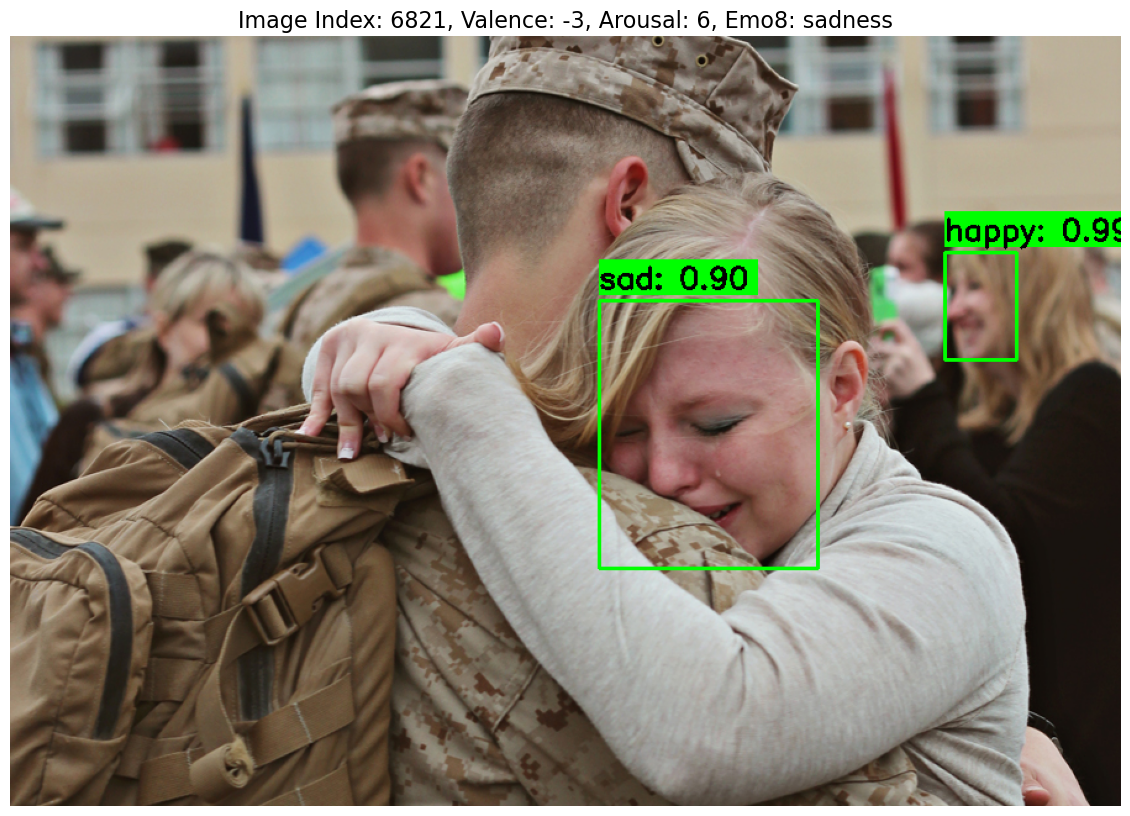

Base model (365 categories):
  hospital_room: 0.2410
  nursing_home: 0.1358
  plaza: 0.1203

Mapped model (20 categories):
  depressing: 0.4205
  work: 0.2159
  commercial: 0.1616


In [1326]:
# pick random element from train_indices
random_sample = random.choice(train_indices)
show_pretrained_model_predictions_on_sample(random_sample)

In [1327]:
def show_images_with_context(context = None, threshold = 0.10, indices = list(range(len(df))), max_images=10):
    found_with_context = 0
    random.shuffle(indices)
    print(len(indices))
    for sample_idx in indices:
        scene_tensor = train_scenes_dataset[(sample_idx,)]

        with torch.no_grad():
            mapped_output = scene_model(scene_tensor.unsqueeze(0).to(DEVICE))[0]

        top3_mapped = torch.topk(mapped_output, 3)
        top3_categories = [mapped_categories[idx.item()] for idx in top3_mapped.indices.cpu()]

        # The probability of the context in the top 3 needs to exceed 10%
        top3_probs = torch.softmax(mapped_output, dim=0)[top3_mapped.indices]
        context_prob = 0
        if context in top3_categories:
            context_index = top3_categories.index(context)
            context_prob = top3_probs[context_index].item()

        if context is None or context_prob > threshold:
            show_pretrained_model_predictions_on_sample(sample_idx)
            found_with_context += 1
            if found_with_context >= max_images:
                    break

In [1328]:
# debug_indices = [idx for idx in train_indices if df.loc[idx, 'nr_faces'] == 3]
# show_images_with_context(context=None, indices=debug_indices, max_images=10)

In [1329]:
from deepproblog.engines import ApproximateEngine

heuristic1 = ApproximateEngine.ucs
heuristic2 = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model4v4.pl"), [face_network, scene_network])
model.set_engine(ApproximateEngine(model, 3, heuristic2))
# model.set_engine(ExactEngine(model), cache=False)
model.optimizer = SGD(model, lr_model)

In [1330]:
model.add_tensor_source("faces_train", train_faces_dataset)
model.add_tensor_source("faces_test", test_faces_dataset)

model.add_tensor_source("scenes_train", train_scenes_dataset)
model.add_tensor_source("scenes_test", test_scenes_dataset)

In [1331]:
class FindingEmoDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        super(FindingEmoDataset, self).__init__()
        self.indices = indices
        self.dataset_name = dataset_name
    
    def __getitem__(self, i):
        pass
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        index = self.indices[i]
        row = df.loc[index]
        nr_faces = row['nr_faces']
        sub_images = [Term("face_{}".format(x)) for x in range(nr_faces)]
        images = [
            Term("tensor", Term(f"faces_{self.dataset_name}", Constant(index), Constant(x))) for x in range(nr_faces)
        ]

        sub = {sub_images[x]: images[x] for x in range(nr_faces)}
        return Query(
            Term(f"final_emotion_{nr_faces}",
                 list2term(sub_images),
                 Term("tensor", Term(f"scenes_{self.dataset_name}", Constant(index))),
                 Term(row['emo8'])
            ),
            substitution=sub,
        )
    
train_dataset = FindingEmoDataset(train_indices, "train")
test_dataset = FindingEmoDataset(test_indices, "test")

In [1332]:
def test_query(query):
    results = model.solve([query])
    result = results[0].result
    print(result)

In [1333]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size)

In [1334]:
face_model.train()
scene_model.train()

print("Models put in train mode")

Models put in train mode


In [1335]:
if load_model:
    model.load_state(os.path.join(model_dir, "model4_2_findingemo.zip"))

else:
    train_obj = train_model(
        model,
        train_loader,
        epochs,
        log_iter=log_iter
    )

    # save the model
    model.save_state(os.path.join(model_dir, "model4v4.zip"))

Training  for 5 epoch(s)
Epoch 1
Iteration:  2 	s:87.9762 	Average Loss:  4.21402341075005
0.8000071527830789	0.14999545773816095	0.04999738947876024	0.7500037075981444	0.14999849422464268	0.09999779817721288	0.7999947446179576	0.15000832817915366	0.049996927202888716	0.7500004147509511	0.1499997511494293	0.09999983409961953	0.5	0.3	0.2
Iteration:  4 	s:211.0951 	Average Loss:  10.609850709733918
0.8000169133445406	0.14998895960439385	0.04999412705106561	0.750011043680853	0.14999641462245852	0.09999254169668843	0.8000133115175729	0.1499944025972211	0.04999228588520595	0.7500012240679271	0.14999926555924373	0.09999951037282916	0.5	0.3	0.2
Iteration:  6 	s:206.7615 	Average Loss:  10.450136510364144
0.8000264294559465	0.14998264472610712	0.0499909258179465	0.7499977159390694	0.15001692365497818	0.09998536040595243	0.7999812260133415	0.15002255970976427	0.04999621427689422	0.7500012240679271	0.14999926555924373	0.09999951037282916	0.4999965959226436	0.29999795755358616	0.20000544652377028

KeyboardInterrupt: 

In [ ]:
from deepproblog.evaluate import get_confusion_matrix

face_model.eval()
scene_model.eval()
get_confusion_matrix(model, test_dataset, verbose=1)

         	       	     	 Actual	   	     
         	       	happy	neutral	sad	angry
         	  happy	  299	    259	 50	    0
Predicted	neutral	  207	    454	172	    0
         	    sad	   39	     81	 35	    0
         	  angry	    0	      4	  0	    0
Accuracy:  0.4925
Accuracy 0.4925


In [ ]:
# if load_model:
#     model.load_state(os.path.join(model_dir, "model4_2_findingemo.zip"))

In [ ]:
# get_confusion_matrix(model, test_dataset, verbose=1)